In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# 3. Computation of Equilibrium of the Stochastic Growth Model with Two Factors with Wedges

#### Hasan Cetin

<hr />

## The Parameters

I will use the following parameters:

- $\psi = 0.3$
- $\delta = 0.8$
- $\theta = 0.6$
- $\beta = 0.9$
- $\phi = 0.01$
- $\rho,\rho_c,\rho_h,\rho_d,\rho_p = 0.9$

In [2]:
# functions needed for second order taylor expansion

def gradient(h,f,x):
    # calculates the gradient of f numerically at point x
    # expects f to take in a vector or a number as input
    # perturbs each xi by hi
    # numer of variables/partial derivatives
    #calculate gradient
    if type(x) == np.ndarray:
        x = x.astype(np.float64)
        n = x.size 
        gradient = np.zeros(n)
        for i in range(n):
            y = x.copy()
            y[i] = x[i] + h[i] # perturb xi
            gradient[i] = (f(y) - f(x))/h[i]
    else:
        n = 1
        x = x.astype(np.float64)
        gradient = (f((x + h)) - f(x))/h
    return gradient
    
def jacobian(h, f, x):
    # calculate the jacobian matrix of f numerically at point x with step size h
    # number of variables in argument/partial derivatives
    if type(x) == np.ndarray:
        n = x.size # numer of variables/partial derivatives
    else:
        n = 1
    # number of functions
    if type(f) == np.ndarray:
        m = f.size 
        jdf = np.zeros([m,n], dtype = np.float)
        for i in range(m): # for each function
            jdf[i,:] = gradient(h,f[i],x) # find gradient
    else:
        jdf = gradient(h,f,x) 
    return jdf

def hessian(h,f,x):
    # calculate the hessian matrix of f numerically at point x with step size h
    n = x.size # number of variables in argument/partial derivatives
    x = x.astype(np.float64)
    hdf = np.zeros((n, n))
    gradx = gradient(h,f,x)
    for i in range(n):
        for j in range(n):
            xi = x.copy()
            xj = x.copy()
            xi[i] = x[i] + h[i] # perturb xi
            xj[j] = x[j] + h[j] # perturb xj
            gradhi = gradient(h,f,xi)
            gradhj = gradient(h,f,xj)
            # second derivative based on gradient calls
            hdf[i,j] = (gradhj[i] - gradx[i]) / (2*h[j]) + (gradhi[j] - gradx[j]) / (2*h[i])
    return hdf


In [109]:
class LQ:
    """Our LQ Model"""

    def __init__(self, p=0.9,p_c=0.9,p_h=0.9,p_d=0.9,p_p=0.9, p_g=0.9, δ=0.8, 
    θ=0.7, β=0.6, γ_n=0.01, ψ=0.3, ϕ = 0.05, tol=10e-4, max_iter=10000):
        
        """Parameters and the steady state initialization"""
       
        self.p = p                       # ρ's of the VAR(1) process
        self.p_c = p_c
        self.p_h = p_h
        self.p_d = p_d
        self.p_p = p_p
        self.p_g = p_g

        self.β = β                       # discount factor
        self.θ = θ                       # capital share
        self.ϕ = ϕ                       # steady state gov. spending share
        self.δ = δ                       # depreciation rate of capital
        self.ψ = ψ                       # parameter for valuing leisure
        self.γ_n = γ_n                   # growth rate of population

        self.β_hat = β * (1 + γ_n)       # Normalized beta

        self.max_iter = max_iter         # Maximum iteration
        self.iterations = 0              # Iteration number of the VFI process
        self.tol = tol                   # Tolerance of convergence

        # Steady state values
        self.Λ_1 = ((1/θ)*(1/β - (1-δ))) **(1/(1-θ))
        self.Λ_2 = (1-ϕ)*(self.Λ_1**(1-θ)) - (δ + γ_n)

        self.τ_css, self.τ_hss, self.τ_dss, self.τ_pss = 0, 0, 0, 0
        self.ln_z_ss = 0
        self.ln_k_ss = np.log((1-θ)* (self.Λ_1**(-θ))/(ψ*self.Λ_2 + (1-θ)*(self.Λ_1**(1-θ))))
        self.h_ss = self.Λ_1 * np.exp(self.ln_k_ss)
        self.c_ss = self.Λ_2 * np.exp(self.ln_k_ss)       
        self.y_ss = (np.exp(self.ln_k_ss)**θ) * (self.h_ss)**(1-θ)
        self.ln_g_ss = np.log(ϕ * self.y_ss)
        self.x_ss = (self.γ_n + δ)*np.exp(self.ln_k_ss)
        self.ln_K_ss = self.ln_k_ss
        self.H_ss = self.h_ss
        self.T_ss = - np.exp(self.ln_g_ss)
        
        self.w_ss = (1-θ) * (np.exp(self.ln_k_ss)**(θ)*self.h_ss**(1-θ))/self.h_ss
        self.r_ss = θ * (np.exp(self.ln_k_ss)**(θ)*self.h_ss**(1-θ))/np.exp(self.ln_k_ss)
        

        self.Steady_state = np.array([self.ln_k_ss, self.ln_z_ss, self.τ_css, self.τ_hss, self.τ_dss, self.τ_pss,
                                     self.ln_g_ss, self.ln_K_ss, self.H_ss, self.T_ss, self.ln_k_ss, self.h_ss]).astype(np.float64)
        self.a = np.array([self.ln_k_ss, self.ln_z_ss, self.τ_css, self.τ_hss, self.τ_dss, self.τ_pss, self.ln_g_ss,self.ln_k_ss, self.h_ss]).astype(np.float64)

        
    def Ret(self, X):
        """One-period return function"""
        ln_k, ln_z, τ_c, τ_h, τ_d, τ_p, ln_g, ln_K, H, T, ln_k_prime, h = X[0], X[1], X[
            2], X[3], X[4], X[5], X[6], X[7], X[8], X[9], X[10], X[11]
        Y = np.exp(ln_K)**(self.θ) * (np.exp(ln_z) * H)**(1 - self.θ)
        r = self.θ * (Y/np.exp(ln_K))
        w = (1-self.θ)*(Y/H)
        x = (1+self.γ_n)*np.exp(ln_k_prime) - (1-self.δ)*np.exp(ln_k)

        one = r*np.exp(ln_k)*(1-τ_d)*(1-τ_p)
        two = w*h*(1-τ_h)
        three = T
        four = x*(1-τ_d)
        five = self.δ * np.exp(ln_k) * (τ_p - τ_d*τ_p)

        return np.log((1/(1+τ_c))*(one + two + three - four + five)) + self.ψ * np.log(1 - h) + 0 * np.exp(ln_g)                     

    def QRW(self):
        """Create Jacobian,Hessian matrices and return value at the steady state and create big matrix (to find R,Q,W) correspondingly"""
        """Decomposes Big Matrix into R,Q,W and uses law of motinon to find A,B,C as well."""
        self.Return = np.array(self.Ret(self.Steady_state)).reshape(
            (1, 1))  # Return at steady state
        self.H = hessian(h=10e-4*np.ones(12), f=self.Ret,
                         x=self.Steady_state)  # Hessian
        self.J = (gradient(h=10e-4*np.ones(12), f=self.Ret,
                          x=self.Steady_state)).reshape(12,1)  # Jacobian


        self.M11 = self.Return - np.dot(self.Steady_state,self.J) + 0.5* np.dot(np.dot(self.Steady_state,self.H),self.Steady_state)
        self.M12 = 0.5*(self.J - np.dot(self.H,self.Steady_state).reshape(12,1))
        self.M22 = 0.5*self.H

        self.M1 = np.concatenate((self.M11,self.M12.T),axis=1)
        self.M2 = np.concatenate([self.M12,self.M22], axis=1)
        #Our big matrix to find Q,R,W
        self.big_matrix = np.concatenate((self.M1, self.M2), axis =0)
       
        # # first_row = np.concatenate([self.Return, self.J]).T
        # # rest_of_matrix = np.concatenate([self.J, self.H], axis=1)

        self.Q = self.big_matrix[0:11, 0:11]
        self.R = self.big_matrix[11:, 11:]
        self.W = self.big_matrix[0:11, 11:]

    def Transfer_payment(self, X):
        """Transfer payment's equation with market clearing"""
        k, z, τ_c, τ_h, τ_d, τ_p, g, kp, h = X[0], X[1], X[2], X[3], X[4], X[5], X[6], X[7], X[8]
        y =  (np.exp(k)**(self.θ)) * ((np.exp(z)*h)**(1-self.θ))
        w =  (1-self.θ) *(y/h)
        r =  (self.θ) * (y/np.exp(k))
        x = (1+self.γ_n) * np.exp(kp) - (1-self.δ) * np.exp(k)
        c = (np.exp(k*self.θ)) * ((np.exp(z) * h)**(1 - self.θ)) - x - np.exp(g)

        T = τ_c*c + τ_h*(w * h) + τ_p*(r * np.exp(k) - self.δ * np.exp(k)) + τ_d*(r * np.exp(k) - x -  τ_p*(r * np.exp(k) - self.δ * np.exp(k))) - np.exp(g)

        return T

    def Transfer_taylor(self):
        """ 
        f(x) = f(a) + (x-a)f'(a) = [f(a) - a f'(a)] + f'(a) x
        
        So, the parameter of 1 in X_{1t} is f(a) - a f'(a)

        All the other variables of X_{1t}, X_{2t} and u_t are f'(a)

        """
        a = np.array([self.ln_k_ss, self.ln_z_ss, self.τ_css, self.τ_hss, self.τ_dss, self.τ_pss, self.ln_g_ss,self.ln_k_ss, self.h_ss]).astype(np.float64)
       
        self.fp_a = gradient(h=10e-4*np.ones(9), f=self.Transfer_payment, x=a)
        
        self.one = np.array(self.Transfer_payment(a) - np.dot(a,self.fp_a))
       
        self.Total_params = np.concatenate([self.one.reshape(1,1), self.fp_a.reshape(9,1)])

        return self.Total_params[:-2], self.Total_params[-2:] #First one is the params of X_1t and X_2t variables, second one is the params of u_t


    def theta_and_psi(self):
        """Calculates Ψ and Θ"""
        theta_part, psi_part = self.Transfer_taylor()
        
        aux = np.zeros((2,8))
        aux[0,1] = 1

        self.Θ =  np.concatenate([aux,theta_part.reshape(1,8)])

        self.Ψ = np.array([[0,0], [0,1], psi_part.reshape(2,)])


    def ABC(self):
        """Calculates everything about A and B in levels"""
        self.W_y = self.W[0:8,:]
        self.W_z = self.W[8:,:]

        self.A_y = np.array([[1,0,0,0,0,0,0,0],
                               [0,0,0,0,0,0,0,0],
                               [0,0,self.p,0,0,0,0,0],
                               [0,0,0,self.p_c,0,0,0,0],
                               [0,0,0,0,self.p_h,0,0,0],
                               [0,0,0,0,0,self.p_d,0,0],
                               [0,0,0,0,0,0,self.p_p,0],
                               [0,0,0,0,0,0,0,self.p_g]])

        self.A_z = np.zeros(shape=(8,3))

        self.B_y = np.zeros(shape=(8,2))
        self.B_y[1,0] = 1


    def Normalize(self):
        """Normalizes everything with magical normalization functions to make all the variables ready for Ricatti equation"""
        W_y, W_z, A_y, A_z, B_y = self.W_y, self.W_z, self.A_y, self.A_z, self.B_y
        Θ, Ψ = self.Θ, self.Ψ 

        self.A_tilde_y = np.sqrt(self.β_hat) * (A_y -
                                              B_y @ np.linalg.inv(self.R) @ W_y.T)
        
        self.A_tilde_z = np.sqrt(self.β_hat) * (A_z -
                                              B_y @ np.linalg.inv(self.R) @ W_z.T)

        self.B_tilde_y = np.sqrt(self.β_hat) * B_y

        self.Q_tilde = self.Q - (self.W @ np.linalg.inv(self.R) @ self.W.T)

        self.Q_tilde_y = self.Q_tilde[0:8,0:8]

        self.Q_tilde_z = self.Q_tilde[0:8,8:]

        self.Θ_tilde = np.dot(np.linalg.inv(np.eye(3)+ np.dot(np.dot(Ψ,np.linalg.inv(self.R)),W_z.T)),(Θ - np.dot(np.dot(Ψ,np.linalg.inv(self.R)),W_y.T)))

        self.Ψ_tilde = np.dot(np.linalg.inv(np.eye(3)+ np.dot(np.dot(Ψ,np.linalg.inv(self.R)),W_z.T)),Ψ)
    
        # MAGIC normalization
        self.A_hat = self.A_tilde_y + np.dot(self.A_tilde_z, self.Θ_tilde)
        self.Q_hat = self.Q_tilde_y + np.dot(self.Q_tilde_z, self.Θ_tilde)
        self.B_hat = self.B_tilde_y + np.dot(self.A_tilde_z, self.Ψ_tilde)
        self.A_bar = self.A_tilde_y - self.B_tilde_y @ np.linalg.inv(self.R) @ self.Ψ_tilde.T @ self.Q_tilde_z.T

    def convergence(self):
        self.QRW()
        self.theta_and_psi()
        self.ABC()
        self.Normalize()
        
        self.P_0 = np.zeros((8,8))

        self.P_1 = np.ones((8, 8))  # To be able to start iteration

        #P_0, P_1, Q, A, B, R = self.P_0, self.P_1, self.Q_tilde, self.A_tilde, self.B_tilde, self.R

        while np.max(np.abs(self.P_1 - self.P_0) > self.tol) and self.iterations < self.max_iter:
            self.P_0 = np.copy(self.P_1)
            self.P_1 = self.Q_hat + self.A_bar.T @ self.P_0 @ self.A_hat - self.A_bar.T @ self.P_0 @ self.B_hat @ np.linalg.inv(self.R + self.B_tilde_y.T @ self.P_0 @ self.B_hat ) @ self.B_tilde_y.T @ self.P_0 @ self.A_hat
            self.iterations += 1

        if self.iterations < self.max_iter:
            print("Succesfully converged!")
            self.P = np.copy(self.P_1)
            self.F = (np.linalg.inv(self.R + self.B_tilde_y.T @ self.P_1 @
                  self.B_hat) @ self.B_tilde_y.T @ self.P_1 @ self.A_hat)
        else:
            print("NO CONVERGENCE!!!!!!!!!!!!!!!!!!")

    def Graphics(self):
        self.convergence()
        fig, ax = plt.subplots(1, 2, figsize=(14, 6))

        S1 = np.log(np.linspace(0.95, 1.05, 5))  # Technologies
        S2 = np.linspace(0.1, 2.5, 200)  # Capitals

        for s1 in range(len(S1)):
            values = []
            policy_values = []
            for s2 in range(len(S2)):
                v = np.matmul(np.matmul(np.matrix([1, (S1[s1]) - (self.s1), S2[s2] - self.s2]), self.P), np.matrix(
                    [1, (S1[s1]) - (self.s1), S2[s2] - self.s2]).T).item(0)
                values.append(v)
                k = - np.matmul(self.F + np.matmul(np.linalg.inv(self.R), self.W.T), (np.array(
                    [[1], [(S1[s1]) - (self.s1)], [S2[s2] - self.s2]]))).item(0) + self.d1
                policy_values.append(k)

            ax[0].plot(S2, values, '--',
                       label="z ={}".format(np.round(np.exp(S1[s1]), 2)))
            ax[0].set_xlabel('k')
            ax[0].set_ylabel('V(z,k)')
            ax[0].title.set_text('The graph of V(z,k)')
            ax[0].legend()

            ax[1].plot(S2, policy_values, '--',
                       label="z ={}".format(np.round(np.exp(S1[s1]), 2)))
            ax[1].set_xlabel('k')
            ax[1].set_ylabel("k'")
            ax[1].title.set_text('The graph of optimal policy function')
            ax[1].axline((0, 0), (S2.max(), S2.max()))
            ax[1].legend()

        plt.show()


In [131]:
LQ_model = LQ()
LQ_model.convergence()

Succesfully converged!


In [132]:
np.round(LQ_model.P)

array([[-4.,  1.,  0., -2., -2., -0.,  0.,  0.],
       [ 1., -0., -0., -1.,  0., -1., -0.,  0.],
       [ 1., -0., -0., -0., -0., -0., -0.,  0.],
       [-1., -0., -0.,  1., -0., -0.,  0., -0.],
       [-1.,  0.,  0.,  0., -0., -0.,  0., -0.],
       [-1.,  0.,  0.,  1., -0.,  0.,  0., -0.],
       [-0.,  0., -0.,  1.,  0.,  1.,  0., -0.],
       [ 0., -0., -0., -0., -0., -0.,  0., -0.]])

In [135]:
LQ_model.F

array([[-0.81760973,  0.01643785,  0.03089433,  0.48274433, -0.01526034,
         0.4973206 ,  0.34955394, -0.04286276],
       [-0.19326466,  0.00388554,  0.00730273,  0.11410996, -0.0036072 ,
         0.11755547,  0.08262673, -0.0101318 ]])

In [138]:
class Vaughan:
    def __init__(self, p=0.9,p_c=0.9,p_h=0.9,p_d=0.9,p_p=0.9, p_g=0.9, δ=0.8, 
     θ=0.7, β=0.6, γ_n=0.01, ψ=0.3, ϕ = 0.05):
    
        """Parameters and the steady state initialization"""
        
        self.p = p                       # ρ's of the VAR(1) process
        self.p_c = p_c
        self.p_h = p_h
        self.p_d = p_d
        self.p_p = p_p
        self.p_g = p_g

        self.β = β                       # discount factor
        self.θ = θ                       # capital share
        self.ϕ = ϕ                       # steady state gov. spending share
        self.δ = δ                       # depreciation rate of capital
        self.ψ = ψ                       # parameter for valuing leisure
        self.γ_n = γ_n                   # growth rate of population
        self.β_hat = β * (1 + γ_n)       # Normalized beta

        # Steady state values
        self.Λ_1 = ((1/θ)*(1/β - (1-δ))) **(1/(1-θ))
        self.Λ_2 = (1-ϕ)*(self.Λ_1**(1-θ)) - (δ + γ_n)

        self.τ_css, self.τ_hss, self.τ_dss, self.τ_pss = 0, 0, 0, 0
        self.ln_z_ss = 0
        self.ln_k_ss = np.log((1-θ)* (self.Λ_1**(-θ))/(ψ*self.Λ_2 + (1-θ)*(self.Λ_1**(1-θ))))
        self.h_ss = self.Λ_1 * np.exp(self.ln_k_ss)
        self.c_ss = self.Λ_2 * np.exp(self.ln_k_ss)       
        self.y_ss = (np.exp(self.ln_k_ss)**θ) * (self.h_ss)**(1-θ)
        self.ln_g_ss = np.log(ϕ * self.y_ss)
        self.x_ss = (self.γ_n + δ)*np.exp(self.ln_k_ss)
        self.ln_K_ss = self.ln_k_ss
        self.H_ss = self.h_ss
        self.T_ss = - np.exp(self.ln_g_ss)
    
        self.w_ss = (1-θ) * (np.exp(self.ln_k_ss)**(θ)*self.h_ss**(1-θ))/self.h_ss
        self.r_ss = θ * (np.exp(self.ln_k_ss)**(θ)*self.h_ss**(1-θ))/np.exp(self.ln_k_ss)
        

        self.Steady_state = np.array([self.ln_k_ss, self.ln_z_ss, self.τ_css, self.τ_hss, self.τ_dss, self.τ_pss,
                                        self.ln_g_ss, self.ln_K_ss, self.H_ss, self.T_ss, self.ln_k_ss, self.h_ss]).astype(np.float64)
        self.a = np.array([self.ln_k_ss, self.ln_z_ss, self.τ_css, self.τ_hss, self.τ_dss, self.τ_pss, self.ln_g_ss,self.ln_k_ss, self.h_ss]).astype(np.float64)

    
    def Ret(self, X):
        """One-period return function"""
        ln_k, ln_z, τ_c, τ_h, τ_d, τ_p, ln_g, ln_K, H, T, ln_k_prime, h = X[0], X[1], X[
            2], X[3], X[4], X[5], X[6], X[7], X[8], X[9], X[10], X[11]
        Y = np.exp(ln_K)**(self.θ) * (np.exp(ln_z) * H)**(1 - self.θ)
        r = self.θ * (Y/np.exp(ln_K))
        w = (1-self.θ)*(Y/H)
        x = (1+self.γ_n)*np.exp(ln_k_prime) - (1-self.δ)*np.exp(ln_k)

        one = r*np.exp(ln_k)*(1-τ_d)*(1-τ_p)
        two = w*h*(1-τ_h)
        three = T
        four = x*(1-τ_d)
        five = self.δ * np.exp(ln_k) * (τ_p - τ_d*τ_p)

        return np.log((1/(1+τ_c))*(one + two + three - four + five)) + self.ψ * np.log(1 - h) + 0 * np.exp(ln_g)                     

    def QRW(self):
        """Create Jacobian,Hessian matrices and return value at the steady state and create big matrix (to find R,Q,W) correspondingly"""
        """Decomposes Big Matrix into R,Q,W and uses law of motinon to find A,B,C as well."""
        self.Return = np.array(self.Ret(self.Steady_state)).reshape(
            (1, 1))  # Return at steady state
        self.H = hessian(h=10e-4*np.ones(12), f=self.Ret,
                         x=self.Steady_state)  # Hessian
        self.J = (gradient(h=10e-4*np.ones(12), f=self.Ret,
                          x=self.Steady_state)).reshape(12,1)  # Jacobian


        self.M11 = self.Return - np.dot(self.Steady_state,self.J) + 0.5* np.dot(np.dot(self.Steady_state,self.H),self.Steady_state)
        self.M12 = 0.5*(self.J - np.dot(self.H,self.Steady_state).reshape(12,1))
        self.M22 = 0.5*self.H

        self.M1 = np.concatenate((self.M11,self.M12.T),axis=1)
        self.M2 = np.concatenate([self.M12,self.M22], axis=1)
        #Our big matrix to find Q,R,W
        self.big_matrix = np.concatenate((self.M1, self.M2), axis =0)
       
        # # first_row = np.concatenate([self.Return, self.J]).T
        # # rest_of_matrix = np.concatenate([self.J, self.H], axis=1)

        self.Q = self.big_matrix[0:11, 0:11]
        self.R = self.big_matrix[11:, 11:]
        self.W = self.big_matrix[0:11, 11:]

    def Transfer_payment(self, X):
        """Transfer payment's equation with market clearing"""
        k, z, τ_c, τ_h, τ_d, τ_p, g, kp, h = X[0], X[1], X[2], X[3], X[4], X[5], X[6], X[7], X[8]
        y =  (np.exp(k)**(self.θ)) * ((np.exp(z)*h)**(1-self.θ))
        w =  (1-self.θ) *(y/h)
        r =  (self.θ) * (y/np.exp(k))
        x = (1+self.γ_n) * np.exp(kp) - (1-self.δ) * np.exp(k)
        c = (np.exp(k*self.θ)) * ((np.exp(z) * h)**(1 - self.θ)) - x - np.exp(g)

        T = τ_c*c + τ_h*(w * h) + τ_p*(r * np.exp(k) - self.δ * np.exp(k)) + τ_d*(r * np.exp(k) - x -  τ_p*(r * np.exp(k) - self.δ * np.exp(k))) - np.exp(g)

        return T

    def Transfer_taylor(self):
        """ 
        f(x) = f(a) + (x-a)f'(a) = [f(a) - a f'(a)] + f'(a) x
        
        So, the parameter of 1 in X_{1t} is f(a) - a f'(a)

        All the other variables of X_{1t}, X_{2t} and u_t are f'(a)

        """
        a = np.array([self.ln_k_ss, self.ln_z_ss, self.τ_css, self.τ_hss, self.τ_dss, self.τ_pss, self.ln_g_ss,self.ln_k_ss, self.h_ss]).astype(np.float64)
       
        self.fp_a = gradient(h=10e-4*np.ones(9), f=self.Transfer_payment, x=a)
        
        self.one = np.array(self.Transfer_payment(a) - np.dot(a,self.fp_a))
       
        self.Total_params = np.concatenate([self.one.reshape(1,1), self.fp_a.reshape(9,1)])

        return self.Total_params[:-2], self.Total_params[-2:] #First one is the params of X_1t and X_2t variables, second one is the params of u_t
 
    def theta_and_psi(self):
        """Calculates Ψ and Θ"""
        theta_part, psi_part = self.Transfer_taylor()
        
        aux = np.zeros((2,8))
        aux[0,1] = 1

        self.Θ =  np.concatenate([aux,theta_part.reshape(1,8)])

        self.Ψ = np.array([[0,0], [0,1], psi_part.reshape(2,)])


    def ABC(self):
        """Calculates everything about A and B in levels"""
        self.W_y = self.W[0:8,:]
        self.W_z = self.W[8:,:]

        self.A_y = np.array([[1,0,0,0,0,0,0,0],
                               [0,0,0,0,0,0,0,0],
                               [0,0,self.p,0,0,0,0,0],
                               [0,0,0,self.p_c,0,0,0,0],
                               [0,0,0,0,self.p_h,0,0,0],
                               [0,0,0,0,0,self.p_d,0,0],
                               [0,0,0,0,0,0,self.p_p,0],
                               [0,0,0,0,0,0,0,self.p_g]])

        self.A_z = np.zeros(shape=(8,3))

        self.B_y = np.zeros(shape=(8,2))
        self.B_y[1,0] = 1


    def Normalize(self):
        """Normalizes everything with magical normalization functions to make all the variables ready for Ricatti equation"""
        W_y, W_z, A_y, A_z, B_y = self.W_y, self.W_z, self.A_y, self.A_z, self.B_y
        Θ, Ψ = self.Θ, self.Ψ 

        self.A_tilde_y = np.sqrt(self.β_hat) * (A_y -
                                              B_y @ np.linalg.inv(self.R) @ W_y.T)
        
        self.A_tilde_z = np.sqrt(self.β_hat) * (A_z -
                                              B_y @ np.linalg.inv(self.R) @ W_z.T)

        self.B_tilde_y = np.sqrt(self.β_hat) * B_y

        self.Q_tilde = self.Q - (self.W @ np.linalg.inv(self.R) @ self.W.T)

        self.Q_tilde_y = self.Q_tilde[0:8,0:8]

        self.Q_tilde_z = self.Q_tilde[0:8,8:]

        self.Θ_tilde = np.dot(np.linalg.inv(np.eye(3)+ np.dot(np.dot(Ψ,np.linalg.inv(self.R)),W_z.T)),(Θ - np.dot(np.dot(Ψ,np.linalg.inv(self.R)),W_y.T)))

        self.Ψ_tilde = np.dot(np.linalg.inv(np.eye(3)+ np.dot(np.dot(Ψ,np.linalg.inv(self.R)),W_z.T)),Ψ)
    
        # MAGIC normalization
        self.A_hat = self.A_tilde_y + np.dot(self.A_tilde_z, self.Θ_tilde)
        self.Q_hat = self.Q_tilde_y + np.dot(self.Q_tilde_z, self.Θ_tilde)
        self.B_hat = self.B_tilde_y + np.dot(self.A_tilde_z, self.Ψ_tilde)
        self.A_bar = self.A_tilde_y - self.B_tilde_y @ np.linalg.inv(self.R) @ self.Ψ_tilde.T @ self.Q_tilde_z.T
    

    def Ham(self):
        h11 = np.linalg.inv(self.A_hat)
        h12 = np.linalg.inv(self.A_hat) @ self.B_hat @ np.linalg.inv(self.R) @ self.B_tilde_y.T
        h21 = self.Q_hat @ np.linalg.inv(self.A_hat)
        h22 = self.Q_hat @ np.linalg.inv(self.A_hat) @ self.B_hat @ np.linalg.inv(self.R) @ self.B_tilde_y.T + self.A_bar.transpose()

        self.H =  np.block([[h11,h12], [h21,h22]])

    def decomposition(self):
        """Decompose Hamiltonian matrix and order the eigenvalues and eigenvectors"""
        h = self.H.shape[0] // 2  # Midpoint

        val, vec = np.linalg.eig(self.H)

        idx_sorted = np.argsort(val)[::-1]  # Order in descending order
        # Reverse the order of the second half
        idx_sorted[h:] = idx_sorted[h:][::-1]

        self.Λ, self.V = np.diag(val[idx_sorted]), vec[:, idx_sorted]

    
    def solving_P_and_F(self):
        """Get P and F"""
        self.QRW()
        self.theta_and_psi()
        self.ABC()
        self.Normalize()
        self.Ham()
        self.decomposition()

        h = self.H.shape[0] // 2
        self.V11, self.V21 = self.V[0:h, 0:h], self.V[h:, 0:h]

        self.P = self.V21 @ np.linalg.inv(self.V11)
        self.F = (np.linalg.inv(self.R + self.B_tilde_y.T @ self.P @
                  self.B_hat) @ self.B_tilde_y.T @ self.P @ self.A_hat)
    

In [139]:
Vaughan_model = Vaughan()

In [140]:
Vaughan_model.solving_P_and_F()

In [141]:
np.round(Vaughan_model.P)

array([[-4.,  1.,  0., -2., -2., -0.,  0.,  0.],
       [ 1., -0., -0., -1.,  0., -1., -0.,  0.],
       [ 1., -0., -0., -0., -0., -0., -0.,  0.],
       [-1., -0., -0.,  1.,  0., -0.,  0., -0.],
       [-1.,  0.,  0.,  0., -0., -0.,  0., -0.],
       [-1.,  0.,  0.,  1., -0.,  0.,  0., -0.],
       [-0.,  0., -0.,  1.,  0.,  1.,  0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [142]:
Vaughan_model.F

array([[-0.81760877,  0.01643785,  0.03089423,  0.48274427, -0.01526036,
         0.49732052,  0.34955396, -0.04286279],
       [-0.19326443,  0.00388554,  0.0073027 ,  0.11410995, -0.00360721,
         0.11755545,  0.08262674, -0.01013181]])

We have the same answers. It is consistent.

## Simulation


In [187]:
Model = LQ()
Model.convergence()

def u(lnk, lnz, tc, th, td, tp, lng):
    return - np.linalg.inv(Model.R + Model.W_z.T @ Model.Ψ) @ (Model.R @ Model.F + Model.W_y.T + Model.W_z.T @ Model.Θ) @ np.array([1, lnk, lnz, tc, th, td, tp, lng])

Θ = Model.Θ
Ψ = Model.Ψ
P = Model.P
F = Model.F

time = 250

#The shocks
shocks = np.random.normal(loc=0.0, scale=0.01, size=(time, 6))

#The variables
τ_c = np.zeros(time)
τ_h = np.zeros(time)
τ_d = np.zeros(time)
τ_p = np.zeros(time)
ln_z = np.zeros(time)
k = np.zeros(time+1)
ln_g = np.zeros(time)
h = np.zeros(time)
T = np.zeros(time+1)
K = np.zeros(time+1)
H = np.zeros(time+1)

#initial states
τ_c[0] = 0
τ_h[0] = 0
τ_d[0] = 0
τ_p[0] = 0
k[0] = Model.ln_k_ss
ln_z[0] = Model.ln_z_ss
ln_g[0] = Model.ln_g_ss
T[0] = -np.exp(ln_g[0])
h[0] = Model.h_ss
K[0] = Model.ln_k_ss
H[0] = Model.h_ss

Succesfully converged!


In [188]:
u(Model.ln_k_ss, Model.ln_z_ss, Model.τ_css, Model.τ_hss, Model.τ_dss, Model.τ_pss, Model.ln_g_ss)

array([-2.87140369,  0.64669423])

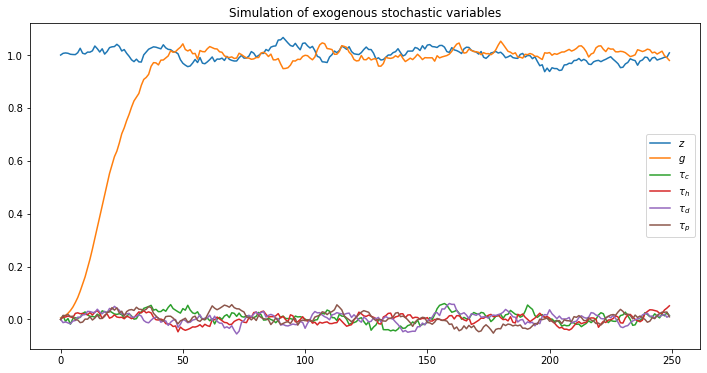

In [189]:
for i in range(time-1): 
    τ_c[i+1] = Model.p_c * τ_c[i] + shocks[i,0]
    τ_h[i+1] = Model.p_h * τ_h[i] + shocks[i,1]
    τ_d[i+1] = Model.p_d * τ_d[i] + shocks[i,2]
    τ_p[i+1] = Model.p_p * τ_p[i] + shocks[i,3]
    ln_g[i+1] = Model.p_g * ln_g[i] + shocks[i,4]
    ln_z[i+1] = Model.p * ln_z[i] + shocks[i,5]


fig,ax = plt.subplots(figsize=(12,6))


ax.plot(np.exp(ln_z), label='$z$')
ax.plot(np.exp(ln_g), label='$g$')
ax.plot(τ_c, label=r'$τ_c$')
ax.plot(τ_h, label='$τ_h$')
ax.plot(τ_d, label='$τ_d$')
ax.plot(τ_p, label='$τ_p$')
ax.set_title('Simulation of exogenous stochastic variables')
ax.legend()
plt.show()

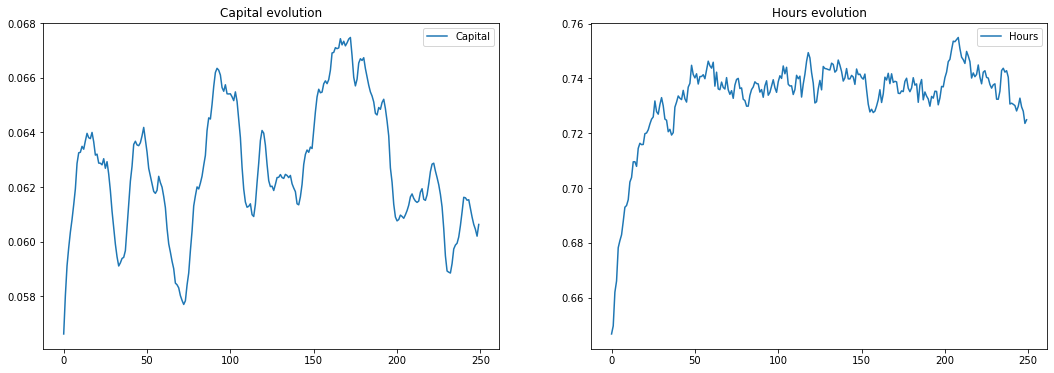

In [191]:
#Simulating endogenous variables

u_sim = np.empty((time,2))

for t in range(time):

    if t ==0:

       u_sim[t,:] = u(Model.ln_k_ss, Model.ln_z_ss, Model.τ_css, Model.τ_hss, Model.τ_dss, Model.τ_pss, Model.ln_g_ss)

    if t>0:

        u_sim[t,:] = u(u_sim[t-1, 0], ln_z[t], τ_c[t], τ_h[t], τ_d[t], τ_p[t], ln_g[t])

fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(np.exp(u_sim[:,0]), label='Capital')
ax[0].set_title('Capital evolution')
ax[0].legend()

ax[1].plot(u_sim[:,1], label='Hours')
ax[1].set_title('Hours evolution')
ax[1].legend()

plt.show()

Because we used market clearing conditions to find aggregate variables, K and H will be equivalent to k and h.

In [227]:
### Generate series for all variables:

### Investment, consumption, leisure, output, wage, rental rate:

# Allocate memory:

i_sim = np.empty(time)     # Investment simulation.
c_sim = np.empty(time)     # Consumption simulation.
T_sim = np.empty(time)     # Gov Transfers simulation.
y_sim = np.empty(time)     # Output simulation.
w_sim = np.empty(time)     # Wage simulation.
r_sim = np.empty(time)     # Rental rate simulation.


for t in range(time):

    if t == 0:
    
       i_sim[0] = (1+ Model.γ_n) * np.exp(u_sim[t, 0]) - (1-Model.δ) * np.exp(Model.ln_k_ss)
    if t>0:

        i_sim[t] = (1+ Model.γ_n) * np.exp(u_sim[t, 0]) - (1-Model.δ) * np.exp(u_sim[t-1, 0])
    
    c_sim[t] = (np.exp(u_sim[t,0]*Model.θ)) * ((np.exp(ln_z[t]) * u_sim[t,1])**(1 - Model.θ)) - i_sim[t] - np.exp(ln_g[t])
    y_sim[t] = (np.exp(u_sim[t,0])**(Model.θ)) * ((np.exp(ln_z[t])*u_sim[t,1])**(1-Model.θ))
    w_sim[t] = (1-Model.θ) *(y_sim[t]/u_sim[t,1])
    r_sim[t] = (Model.θ) * (y_sim[t]/np.exp(u_sim[t,0]))  

    aux = np.array([[1], [u_sim[t,0]], [ln_z[t]], [τ_c[t]], [τ_h[t]], [τ_d[t]], [τ_p[t]], [ln_g[t]]])
    T_sim[t] = np.dot(Model.Θ[2,:], aux)

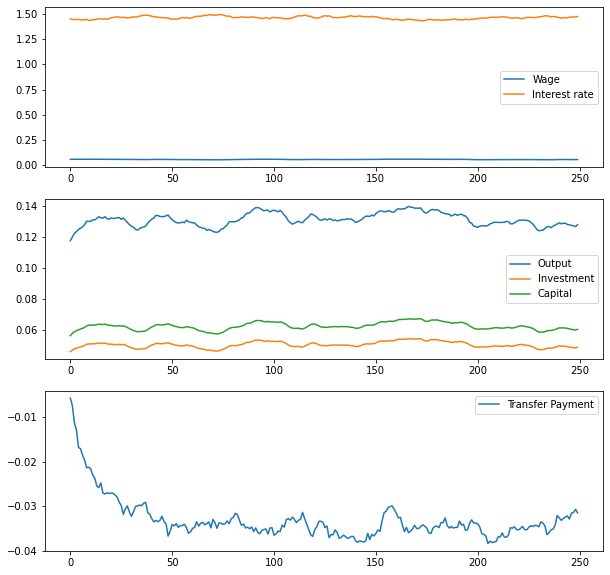

In [228]:
fig, ax = plt.subplots(3, figsize=(10,10))

ax[0].plot(w_sim, label="Wage")
ax[0].plot(r_sim, label="Interest rate")
ax[0].legend()

ax[1].plot(y_sim, label="Output")
ax[1].plot(i_sim, label="Investment")
ax[1].plot(np.exp(u_sim[:,0]), label="Capital")
ax[1].legend()

ax[2].plot(T_sim, label="Transfer Payment")
ax[2].legend()

plt.show()

## Dividends, Accounting Profits and Stock Valuation Simulation

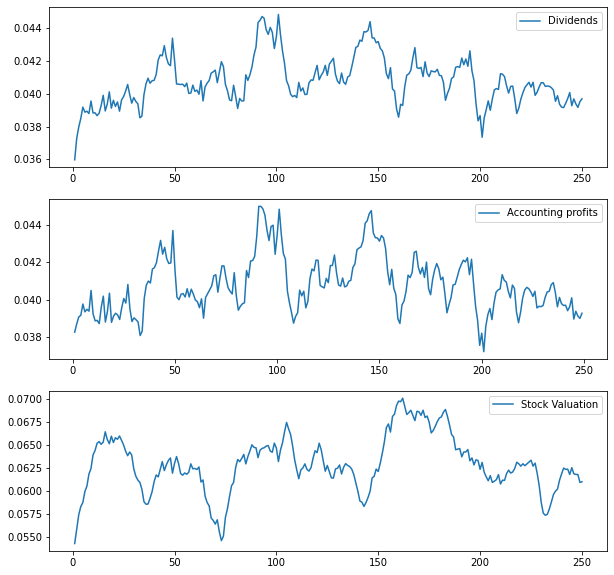

In [213]:
# Allocate memory:

k_sim = np.empty(time, dtype=float)

# Capital of each period:

k_sim[0] = np.exp(Model.ln_k_ss)

# Capital chosen for tomorrow:

kp_sim = np.exp(u_sim[:, 0])

# Labor simulation:

h_sim = u_sim[:, 1]

# The capital for tomorrow is the capital selected today:

k_sim[1:] = kp_sim[0:-1]

# Dividends:

d_sim = y_sim - w_sim * h_sim - (1 + τ_d) * i_sim

# Accounting profits:

pr_sim = d_sim[0:-1] + k_sim[1:] - k_sim[0:-1]

#Stock valuation:

v_sim = (1 + τ_d) * k_sim


fig, ax = plt.subplots(3, figsize=(10,10))
ax[0].plot(np.linspace(1, time, time), d_sim, label = "Dividends")
ax[0].legend()
ax[1].plot(np.linspace(1, time-1, time-1), pr_sim, label = "Accounting profits")
ax[1].legend()
ax[2].plot(np.linspace(1, time, time), v_sim, label = "Stock Valuation")
ax[2].legend()
plt.show()